# Fraud Detection

## Import required modules

In [17]:
get_ipython().magic(u'matplotlib inline')
from __future__ import division
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd
import seaborn as sns

## Read and preview data

We read the `data_for_student_case.csv` file and preview the data.

In [3]:
data = pd.read_csv('data/data_for_student_case.csv')
data.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [4]:
data.dtypes

txid                              int64
bookingdate                      object
issuercountrycode                object
txvariantcode                    object
bin                             float64
amount                          float64
currencycode                     object
shoppercountrycode               object
shopperinteraction               object
simple_journal                   object
cardverificationcodesupplied     object
cvcresponsecode                   int64
creationdate                     object
accountcode                      object
mail_id                          object
ip_id                            object
card_id                          object
dtype: object

In [5]:
for x in data.columns:
    unique_values = set(data[x])
    if len(unique_values) < 100:
        print x,": ", unique_values


txvariantcode :  set(['visasignature', 'visaplatinum', 'mc', 'visacorporate', 'visagold', 'visaclassic', 'mcdebit', 'electron', 'visa', 'visabusiness', 'visadebit', 'visapurchasing', 'vpay', 'mccredit', 'cirrus'])
currencycode :  set(['MXN', 'SEK', 'AUD', 'GBP', 'NZD'])
shopperinteraction :  set(['ContAuth', 'Ecommerce', 'POS'])
simple_journal :  set(['Refused', 'Settled', 'Chargeback'])
cardverificationcodesupplied :  set([False, True, nan])
cvcresponsecode :  set([0, 1, 2, 3, 5])
accountcode :  set(['UKAccount', 'APACAccount', 'SwedenAccount', 'MexicoAccount'])


In [6]:
data.describe() #the only relevant desciption is the amount attribute

,txid,bin,amount,cvcresponsecode
count,290382.000000,290242.000000,2.903820e+05,290382.000000
mean,279916.750673,485254.586238,2.936462e+04,0.769004
std,138437.214796,37015.528140,6.829927e+04,0.508933
min,1.000000,400000.000000,5.000000e+01,0.000000
25%,218232.250000,462239.000000,4.400000e+03,0.000000
50%,304071.500000,475139.000000,7.095000e+03,1.000000
75%,387592.750000,518652.000000,1.589500e+04,1.000000
max,482734.000000,676883.000000,2.785840e+06,5.000000


## Preprocessing

Some preprocessing steps that we try to apply are:
* Remove the `refused` transactions, because their fraudulent ambiguity
* Transform creationdate and bookingdate to pandas datetime
* Map float columns which supposed to be categorical / identifier (`bin` and `cvcresponsecode`)
* Assign fraudulent label based on `simple_journal` attribute (fraudulent = 1 if simple_journal='chargeback', else fraudulent = 0)

### Remove 'refused' transactions

In [7]:
data_preproc = data.loc[data['simple_journal'] != 'Refused'].copy()
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### Transform date to pandas datetime

In [8]:
data_preproc['creationdate'] = pd.to_datetime(data_preproc['creationdate'])
data_preproc['bookingdate'] = pd.to_datetime(data_preproc['bookingdate'])

In [9]:
data_preproc[['bookingdate','creationdate']].dtypes

bookingdate     datetime64[ns]
creationdate    datetime64[ns]
dtype: object

### Map to categorical datatype

In [10]:
data_preproc['bin'] = data_preproc['bin'].astype(int)
data_preproc['bin'] = data_preproc['bin'].astype(str)
data_preproc['txid'] = data_preproc['txid'].astype(str)
for category_column in ["txvariantcode","currencycode","shopperinteraction","simple_journal","cardverificationcodesupplied","cvcresponsecode","accountcode"]:  
    data_preproc[category_column] = data_preproc[category_column].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                     datetime64[ns]
issuercountrycode                       object
txvariantcode                         category
bin                                     object
amount                                 float64
currencycode                          category
shoppercountrycode                      object
shopperinteraction                    category
simple_journal                        category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
dtype: object

### Convert amount to EURO currencies

In [12]:
from currency_converter import CurrencyConverter

currency_converter = CurrencyConverter()
data_preproc['amount_euro'] = map(lambda x,y: currency_converter.convert(x,y, 'EUR'), data_preproc['amount'],data_preproc['currencycode'])
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_euro
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,2809.743914
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1946.875027
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,6499.700814
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,4765.290991
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,3898.086079


### Apply fraudulent label

In [13]:
data_preproc['is_fraud'] = data_preproc.apply(lambda x: 1 if x['simple_journal'] == "Chargeback" else 0, axis=1)
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_euro,is_fraud
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,2809.743914,1
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1946.875027,1
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,6499.700814,1
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,4765.290991,1
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,3898.086079,1


In [14]:
data_preproc['is_fraud'] = data_preproc['is_fraud'].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                     datetime64[ns]
issuercountrycode                       object
txvariantcode                         category
bin                                     object
amount                                 float64
currencycode                          category
shoppercountrycode                      object
shopperinteraction                    category
simple_journal                        category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
amount_euro                            float64
is_fraud                              category
dtype: object

## Visualization Task
We try the following visualization:
* Distribution histogram
* Heat map
* Scatter plot
* Bar chart
* Box plot

### Distribution histogram

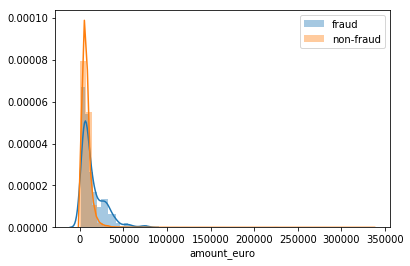

In [24]:
fraud = data_preproc.loc[data_preproc['is_fraud'] == 1]
non_fraud = data_preproc.loc[data_preproc['is_fraud'] == 0]
plt.figure("Amount Distribution (Fraud vs Non-Fraud)")
sns.distplot(fraud['amount_euro'], label="fraud")
sns.distplot(non_fraud['amount_euro'], label="non-fraud")
plt.legend()
plt.show()


### Heat map

We try to plot a heat map of issuercountrycode vs shoppercountrycode in regards of percentage of fraudulent transaction

In [15]:
data_preproc.loc[(data_preproc['issuercountrycode'] != data_preproc['shoppercountrycode']) & (data_preproc['is_fraud'] == 1)]

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_euro,is_fraud
23,24,2015-11-23 16:34:28,MX,mccredit,518853,129900.0,MXN,US,Ecommerce,Chargeback,True,0,2015-07-26 22:22:29,MexicoAccount,email100813,ip352385,card236034,5632.495902,1
58646,152850,2015-10-23 06:45:46,US,mccredit,528725,5500.0,GBP,GB,ContAuth,Chargeback,False,0,2015-08-28 17:46:17,UKAccount,email325211,ip172354,card10824,6193.484454,1
58661,195889,2015-11-10 14:41:13,GB,mccredit,542011,23200.0,GBP,BG,Ecommerce,Chargeback,True,1,2015-10-23 15:22:37,UKAccount,email230289,ip339787,card67262,26125.243517,1
58664,197598,2016-03-05 05:35:41,JO,visaclassic,474701,6420.0,GBP,GB,Ecommerce,Chargeback,True,1,2015-10-26 18:11:44,UKAccount,email343093,ip227405,card152658,7229.485490,1
58672,201259,2015-11-19 13:48:37,GB,mccredit,543460,5350.0,GBP,NG,ContAuth,Chargeback,False,0,2015-10-31 20:04:13,UKAccount,email326146,ip142729,card121188,6024.571242,1
266050,450561,2015-07-23 10:52:24,NL,mccredit,522078,24900.0,SEK,DE,Ecommerce,Chargeback,True,1,2015-07-06 02:51:21,SwedenAccount,email331518,ip62555,card228065,2511.599758,1
266052,450632,2015-07-21 05:53:58,GB,visadebit,475714,32900.0,SEK,SE,Ecommerce,Chargeback,True,1,2015-07-09 02:32:43,SwedenAccount,email235494,ip200377,card6516,3318.539439,1
266069,452322,2015-10-29 08:33:20,FI,mcdebit,543065,427500.0,SEK,SE,Ecommerce,Chargeback,True,1,2015-09-11 08:26:18,SwedenAccount,email175871,ip160664,card132661,43120.839217,1
266072,452360,2015-11-07 07:12:35,MX,mccredit,547046,620000.0,SEK,SE,Ecommerce,Chargeback,True,1,2015-09-13 15:21:36,SwedenAccount,email77101,ip174481,card200013,62537.825298,1
266073,452379,2016-01-23 05:48:52,FI,visadebit,492010,538500.0,SEK,SE,Ecommerce,Chargeback,True,1,2015-09-14 10:42:32,SwedenAccount,email253545,ip165998,card115126,54317.127295,1
